In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pathlib import Path
import plotly.express as px
import scipy
from skimage import color, filters, exposure, measure, morphology, util
from segmentflow import segment, view
%load_ext autoreload
%autoreload 2

## Load images

In [8]:
def save_F83_01_bh750():
    imgs_path = Path('../data/F83_01_raw')
    imgs = segment.load_images(
        imgs_path,
        slice_crop=None,
        file_suffix='.tiff'
    )
    imgs_res = segment.preprocess(
        imgs, median_filter=True, rescale_intensity_range=[25.5, 99.98]
    )
    bh_example_img = imgs_res[750, ...]
    return bh_example_img
bh750 = save_F83_01_bh750()

Loading images...
--> Images loaded as 3D array:  (996, 1014, 994)
Preprocessing images...
--> Applying median filter...
--> Rescaling intensities to percentile range [25.5, 99.98]...
--> Preprocessing complete.


AttributeError: module 'segmentflow.view' has no attribute 'image'

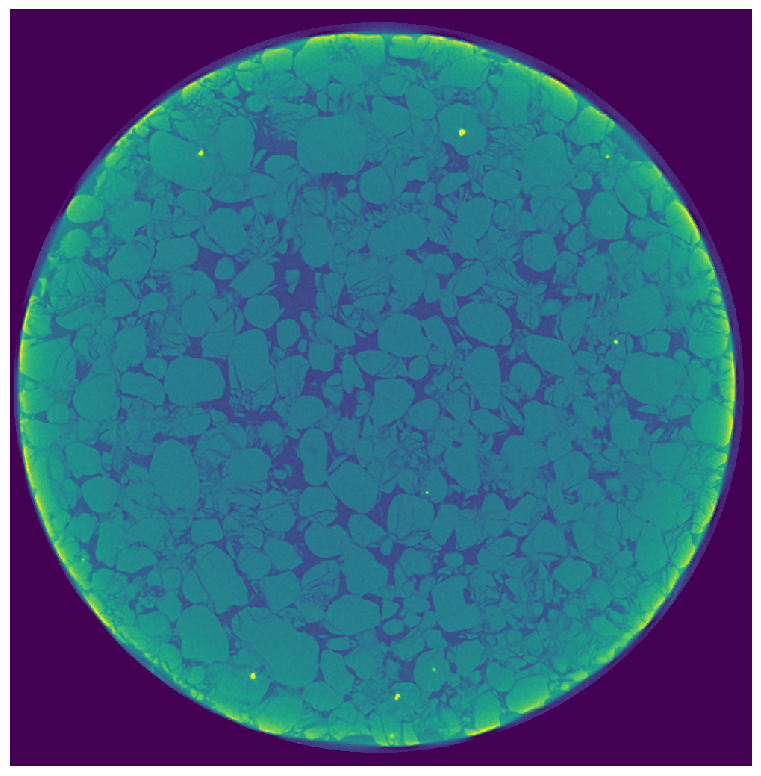

In [10]:
import imageio.v3 as iio
iio.imwrite(Path('../data/F83_01_bh750.tif'), bh750)
fig, ax = view.images(
    bh750,
    fig_w=7.5,
    dpi=100
)

## Reduce beam hardening artifact

- copy image
- min threshold mask
- replace masked region with mean value
- large gaussian filter on copy
- min threshold mask blurred image
- subtract from full iamge

Plotting images: [250, 500, 750]


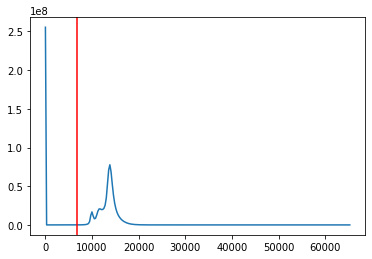

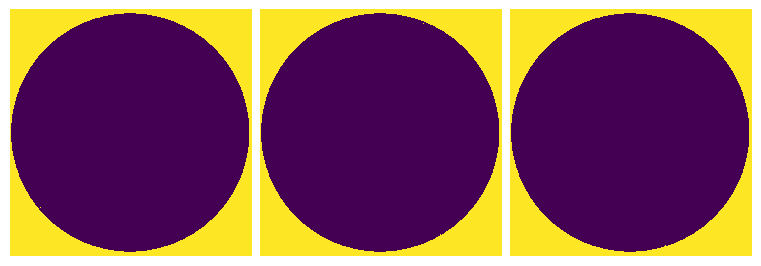

In [7]:
thresh_val = filters.threshold_otsu(bh750)
fig, ax = view.histogram(bh750)
ax.axvline(thresh_val, c='red')
fig, axes = view.slices(imgs < thresh_val, slices=slices)
plt.show()

Plotting images: [250, 500, 750]


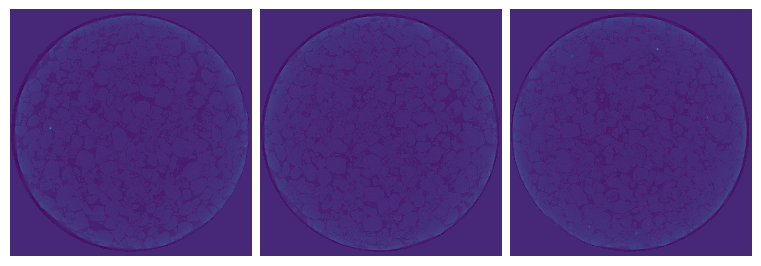

In [8]:
imgs_bg = imgs.copy()
imgs_bg[imgs < thresh_val] = np.median(imgs)
fig, axes = view.slices(imgs_bg, slices=slices)
plt.show()

Plotting images: [250, 500, 750]


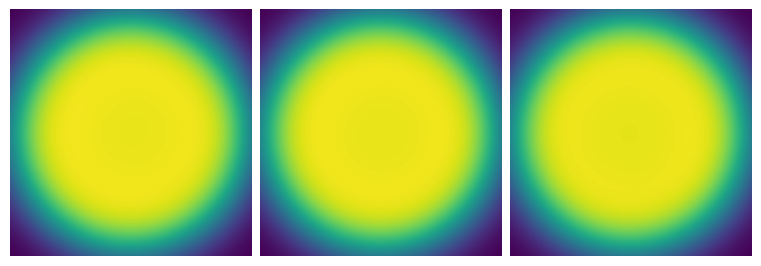

In [9]:
imgs_bg = filters.gaussian(imgs, sigma=imgs.shape[0]/10)
fig, axes = view.slices(imgs_bg, slices=slices)
plt.show()

Plotting images: [250, 500, 750]


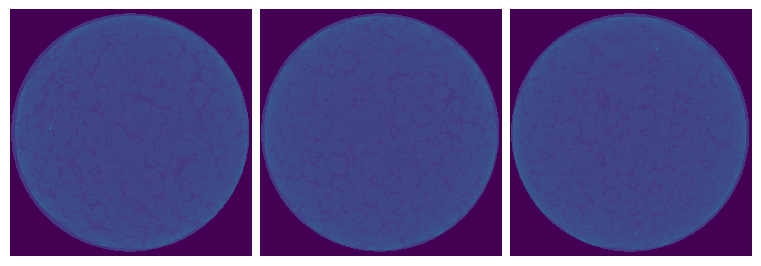

In [10]:
imgs_pre = imgs - imgs_bg
fig, axes = view.slices(imgs_pre, slices=slices)
plt.show()

## Rescale intensity

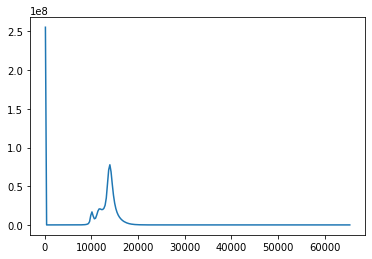

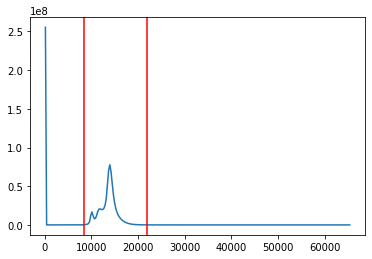

In [11]:
preview_rescale = True
if preview_rescale:
    # imgs_med = segment.preprocess(imgs_pre, median_filter=True)
    imgs_med = imgs_pre
    med_hist, med_bins_centers = exposure.histogram(imgs_med)
    fig, ax = plt.subplots()
    ax.plot(med_bins_centers, med_hist)
    lo = np.percentile(imgs_med, 25.5)
    hi = np.percentile(imgs_med, 99.98)
    fig, ax = plt.subplots()
    ax.plot(med_bins_centers, med_hist)
    ax.axvline(lo, c='red')
    ax.axvline(hi, c='red')
    plt.show()

Preprocessing images...
--> Applying median filter...
--> Rescaling intensities to percentile range [25.5, 99.98]...
--> Preprocessing complete.
Plotting images: [250, 500, 750]


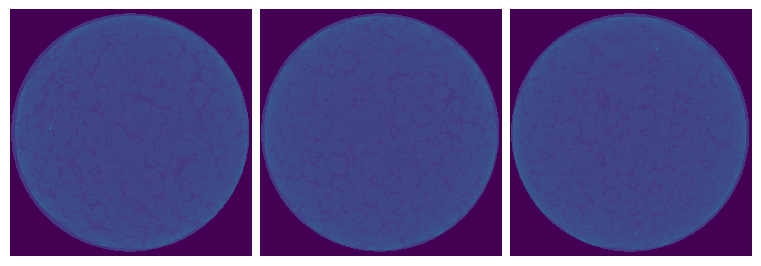

In [12]:
imgs_res = segment.preprocess(
    imgs_pre, median_filter=True, rescale_intensity_range=[25.5, 99.98])
fig, axes = view.plot_slices(
    imgs_res,
    slices=slices,
    print_slices=True,
    imgs_per_row=None,
    fig_w=7.5,
    dpi=100
)

Plotting images: [250, 500, 750]


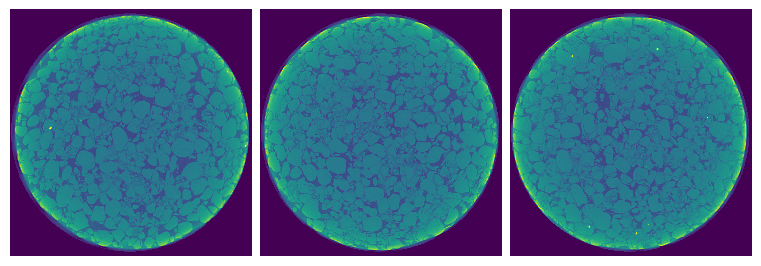

In [13]:
fig, axes = view.plot_slices(
    imgs_res,
    slices=slices,
    print_slices=True,
    imgs_per_row=None,
    fig_w=7.5,
    dpi=100
)

Preprocessing images...
--> Applying median filter...
--> Rescaling intensities to percentile range [25.5, 99.98]...
--> Preprocessing complete.
Plotting images: [250, 500, 750]


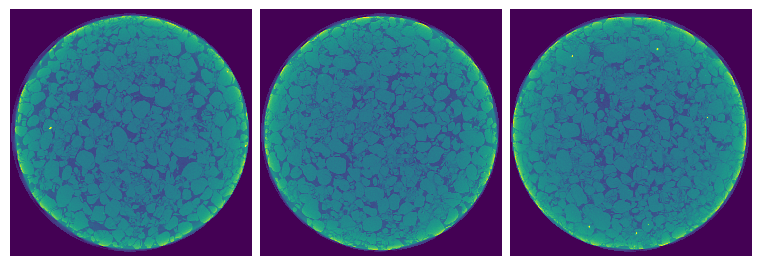

In [4]:
imgs_med = None
imgs_pre = segment.preprocess(
    imgs, median_filter=True, rescale_intensity_range=[25.5, 99.98])
fig, axes = view.plot_slices(
    imgs_pre,
    slices=slices,
    print_slices=True,
    imgs_per_row=None,
    fig_w=7.5,
    dpi=100
)

In [5]:
# segment.save_images(imgs_med, Path('../data/F83_01_pre'))

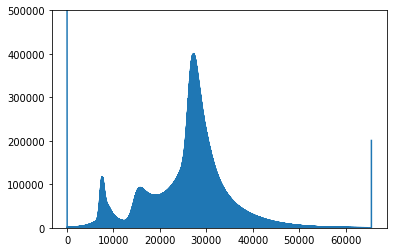

In [6]:
hist, bins_centers = exposure.histogram(imgs_pre)
fig, ax = plt.subplots()
ax.plot(bins_centers, hist)
ax.set_ylim([0, 5e5])
plt.show()

Calculating thresholds from local minima...
--> 3 peak(s) found: [7808, 16256, 27520]
--> 2 minima found: [11904, 19072]


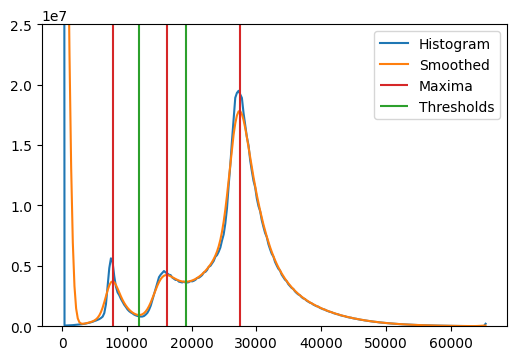

In [7]:
thresholds, fig, ax = segment.threshold_multi_min(
    imgs_pre, nbins=256, nthresholds='all', return_fig_ax=True,
    ylims=[0, 2.5e7], plt_kwargs={'dpi': 100})
plt.show()

## Failed semantic seg

Plotting images: [250, 500, 750]


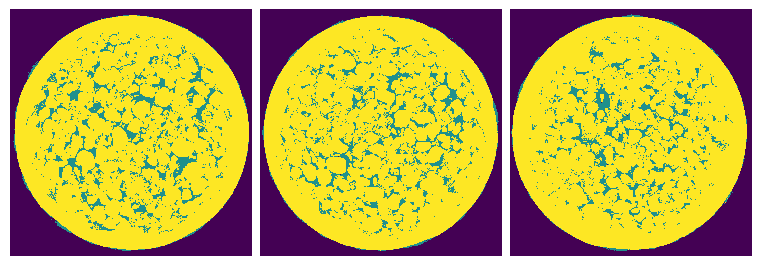

imgs_semantic = 0


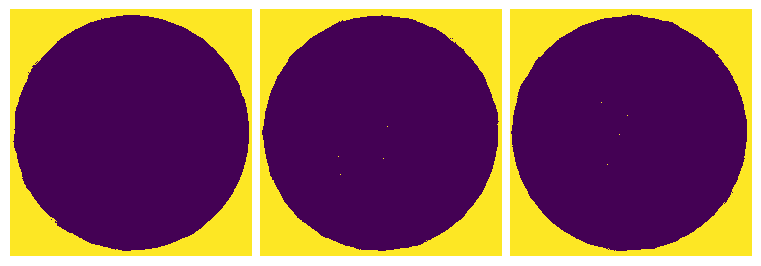

imgs_semantic = 1


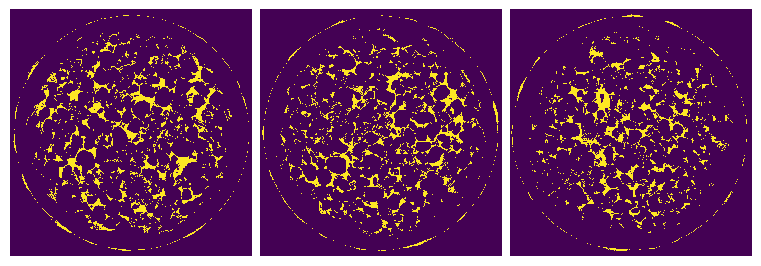

imgs_semantic = 2


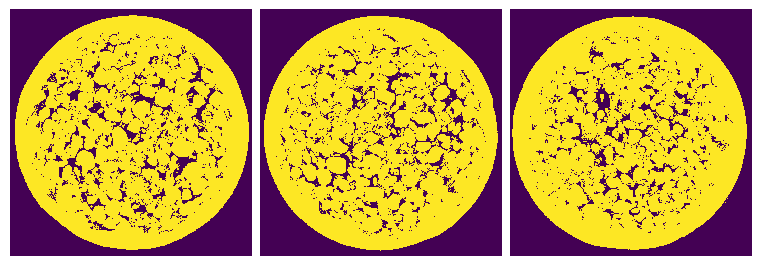

In [8]:
imgs_semantic = segment.isolate_classes(imgs_pre, thresholds)
fig, axes = view.plot_slices(imgs_semantic, slices=slices)
plt.show()
for i in range(len(thresholds) + 1):
    print('imgs_semantic =', i)
    fig, axes = view.plot_slices(
        imgs_semantic==i,
        slices=slices,
        print_slices=False,
        fig_w=7.5,
        dpi=100
    )
    plt.show()

Segmenting images...
--> Number of particle(s) before border exclusion:  16526
--> Excluding border particles...
--> Segmentation complete. 15662 particle(s) segmented.


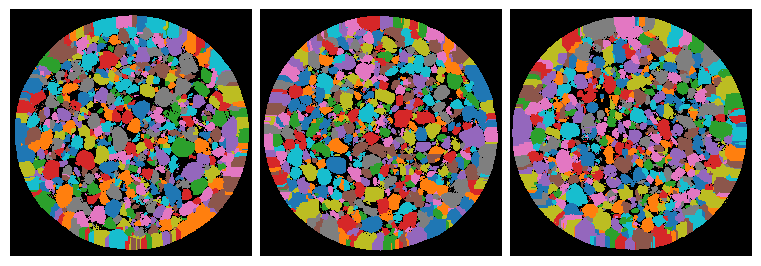

In [9]:
imgs = None
imgs_med = None
imgs_res = None
imgs_labeled = segment.watershed_segment(
    imgs_semantic==len(thresholds),
    min_peak_distance=6,
    exclude_borders=True,
    return_dict=False
)
fig, axes = view.plot_color_labels(
    imgs_labeled,
    slices=slices,
    fig_w=7.5,
    dpi=100
)

In [25]:
imgs_labeled_unique = np.unique(imgs_labeled)
print(f'{imgs_labeled_unique.shape=}')
print(f'{imgs_labeled_unique[:10]=}')

imgs_labeled_unique.shape=(15663,)
imgs_labeled_unique[:10]=array([  0, 645, 646, 647, 651, 652, 653, 654, 655, 656], dtype=uint16)


In [10]:
merged_labels_dir_path = Path('../results/F83_01_merged_labels')
imgs_merged = segment.merge_segmentations(imgs_semantic, imgs_labeled)
segment.save_images(imgs_merged, merged_labels_dir_path)

996 image(s) saved to: C:\Users\gusb\Research\mhe-analysis\nbs\results\F83_01_merged_labels


Loading images...
--> Images loaded as 3D array:  (996, 1014, 994)


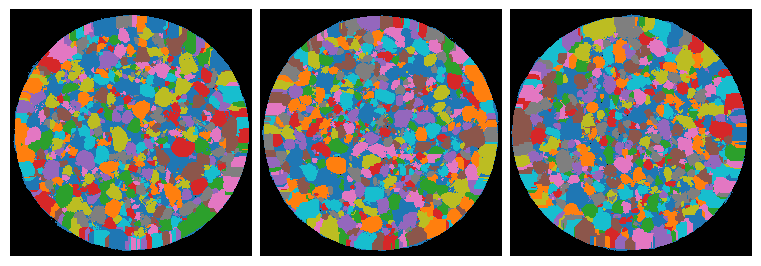

In [29]:
merged_labels_dir_path = Path('C:/Users/gusb/Documents/00-research-docs/F83_01_merged_labels')
imgs_merged = segment.load_images(merged_labels_dir_path, file_suffix='.tif')
fig, axes = view.plot_color_labels(
    imgs_merged,
    slices=slices,
    fig_w=7.5,
    dpi=100
)
plt.show()

In [30]:
imgs_merged_unique = np.unique(imgs_merged)
print(f'{imgs_merged_unique.shape=}')
print(f'{imgs_merged_unique[:10]=}')
print(f'{imgs_merged_unique[-1]=}')

imgs_merged_unique.shape=(15664,)
imgs_merged_unique[:10]=array([  0,   1, 645, 646, 647, 651, 652, 653, 654, 655], dtype=uint16)
imgs_merged_unique[-1]=16526
